In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import random
import os

from IPython.display import Javascript


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# %cd /content/drive/My Drive/Colab Notebooks/project/causal_vote
# !ls

- **Research Question 1: In the democratic party, would receiving over-median financial support cause a higher probability that the candidate gets elected?**
- **Research Question 2: In the democratic party, whether endorsements affected he or she won his or her primary and has advanced to November.**

# Import Data

In [4]:
file = 'dem_candidates.csv'
dem_candidates = pd.read_csv(file)
dem_candidates.head(3)

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Biden Endorsed?,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?
0,Anthony White (Alabama),AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Christopher Countryman,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Doug ""New Blue"" Smith",AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
all_candidates_financial18 = pd.read_csv("weball18.txt", sep="|", 
                 names=["CAND_ID", "CAND_NAME","CAND_ICI","PTY_CD","CAND_PTY_AFFILIATION","TTL_RECEIPTS","TRANS_FROM_AUTH","TTL_DISB","TRANS_TO_AUTH","COH_BOP","COH_COP","CAND_CONTRIB","CAND_LOANS","OTHER_LOANS", "CAND_LOAN_REPAY","OTHER_LOAN_REPAY","DEBTS_OWED_BY","TTL_INDIV_CONTRIB","CAND_OFFICE_ST","CAND_OFFICE_DISTRICT","SPEC_ELECTION","PRIM_ELECTION","RUN_ELECTION","GEN_ELECTION","GEN_ELECTION_PRECENT","OTHER_POL_CMTE_CONTRIB","POL_PTY_CONTRIB","CVG_END_DT","INDIV_REFUNDS","CMTE_REFUNDS"])
all_candidates_financial18.head(3)

,CAND_ID,CAND_NAME,CAND_ICI,PTY_CD,CAND_PTY_AFFILIATION,TTL_RECEIPTS,TRANS_FROM_AUTH,TTL_DISB,TRANS_TO_AUTH,COH_BOP,...,SPEC_ELECTION,PRIM_ELECTION,RUN_ELECTION,GEN_ELECTION,GEN_ELECTION_PRECENT,OTHER_POL_CMTE_CONTRIB,POL_PTY_CONTRIB,CVG_END_DT,INDIV_REFUNDS,CMTE_REFUNDS
0,H8AK00132,"SHEIN, DIMITRI",C,1,DEM,209916.04,0.0,209574.16,0.0,0.00,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,12/31/2018,0.0,0.0
1,H6AK00045,"YOUNG, DONALD E",I,2,REP,1234680.31,0.0,1387687.05,0.0,269726.86,...,NaN,NaN,NaN,NaN,NaN,559861.9,0.0,12/31/2018,2700.0,500.0
2,H8AK00116,"LEDOUX, GABRIELLE R",C,2,REP,0.00,0.0,540033.00,0.0,479.00,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,09/30/2018,0.0,0.0


# Exploratory Data Analysis

## Data Preparation for Research Question 1

### Normalize Name Format to be <first_name> <last_name> (all uppercase) to merge two dataframes

In [ ]:
# add full name column to all_candidates_financial18 help merging two dataframes
all_candidates_financial18['s1_last_name'] = all_candidates_financial18['CAND_NAME'].apply(lambda x : x.split(', ')[0].upper())
all_candidates_financial18['s1_first_name'] = all_candidates_financial18['CAND_NAME'].apply(lambda x : x.split(', ')[-1].split(' ')[0].upper())
all_candidates_financial18['s1_full_name'] = all_candidates_financial18['s1_first_name'] + ' ' + all_candidates_financial18['s1_last_name']
all_candidates_financial18 = all_candidates_financial18.drop(columns=['s1_last_name', 's1_first_name'])
all_candidates_financial18.head(3)

,CAND_ID,CAND_NAME,CAND_ICI,PTY_CD,CAND_PTY_AFFILIATION,TTL_RECEIPTS,TRANS_FROM_AUTH,TTL_DISB,TRANS_TO_AUTH,COH_BOP,...,PRIM_ELECTION,RUN_ELECTION,GEN_ELECTION,GEN_ELECTION_PRECENT,OTHER_POL_CMTE_CONTRIB,POL_PTY_CONTRIB,CVG_END_DT,INDIV_REFUNDS,CMTE_REFUNDS,s1_full_name
0,H8AK00132,"SHEIN, DIMITRI",C,1,DEM,209916.04,0.0,209574.16,0.0,0.00,...,NaN,NaN,NaN,NaN,0.0,0.0,12/31/2018,0.0,0.0,DIMITRI SHEIN
1,H6AK00045,"YOUNG, DONALD E",I,2,REP,1234680.31,0.0,1387687.05,0.0,269726.86,...,NaN,NaN,NaN,NaN,559861.9,0.0,12/31/2018,2700.0,500.0,DONALD YOUNG
2,H8AK00116,"LEDOUX, GABRIELLE R",C,2,REP,0.00,0.0,540033.00,0.0,479.00,...,NaN,NaN,NaN,NaN,0.0,0.0,09/30/2018,0.0,0.0,GABRIELLE LEDOUX


In [ ]:
spec_name = []
for i in dem_candidates['Candidate'].to_list():
  curr = i.split(' ')
  for j in range(len(curr)):
    if not curr[j].isalpha():
      spec_name.append(i)
# add full name column to dem_candidates to help merging two dataframes
names = dem_candidates['Candidate'].to_list()
for i in range(len(names)):
  curr = names[i].split(' ')
  if 'Jr.' in curr[-1] or '(' in curr[-1]:
    curr.remove(curr[-1])
  if len(curr) <= 1:
    names[i] = curr[0].upper()
  else:
    names[i] = curr[0].upper() + ' ' + curr[-1].upper()
dem_candidates['s2_full_name'] = names
dem_candidates.head(3)

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?,s2_full_name
0,Anthony White (Alabama),AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ANTHONY WHITE
1,Christopher Countryman,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHRISTOPHER COUNTRYMAN
2,"Doug ""New Blue"" Smith",AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DOUG SMITH


In [ ]:
# add full name column to dem_candidates to help merging two dataframes
names = dem_candidates['Candidate'].to_list()
for i in range(len(names)):
  curr = names[i].split(' ')
  if 'Jr.' in curr[-1] or '(' in curr[-1]:
    curr.remove(curr[-1])
  if len(curr) <= 1:
    names[i] = curr[0].upper()
  else:
    names[i] = curr[0].upper() + ' ' + curr[-1].upper()
dem_candidates['s2_full_name'] = names
dem_candidates.head(3)

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?,s2_full_name
0,Anthony White (Alabama),AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ANTHONY WHITE
1,Christopher Countryman,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHRISTOPHER COUNTRYMAN
2,"Doug ""New Blue"" Smith",AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DOUG SMITH


In [ ]:
# combine two dataframes
combined_df = dem_candidates.merge(all_candidates_financial18, left_on='s2_full_name', right_on='s1_full_name', how='left')
combined_df.shape

(823, 64)

In [ ]:
# select columns that we need
combined_df = combined_df[['Candidate', 'Primary Status', 'Primary %', 'Race',
       'Veteran?', 'LGBTQ?', 'Elected Official?', 'Self-Funder?', 'STEM?',
       'Obama Alum?', 'Party Support?', 'Emily Endorsed?',
       'Guns Sense Candidate?', 'Biden Endorsed?', 'Warren Endorsed? ',
       'Sanders Endorsed?', 'Our Revolution Endorsed?',
       'Justice Dems Endorsed?', 'PCCC Endorsed?', 'Indivisible Endorsed?',
       'WFP Endorsed?', 'VoteVets Endorsed?', 'No Labels Support?',
       'TTL_RECEIPTS']]
combined_df.head(3)

,Candidate,Primary Status,Primary %,Race,Veteran?,LGBTQ?,Elected Official?,Self-Funder?,STEM?,Obama Alum?,...,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?,TTL_RECEIPTS
0,Anthony White (Alabama),Lost,3.42,Nonwhite,Yes,No,No,No,No,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Christopher Countryman,Lost,1.74,White,No,Yes,No,No,No,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Doug ""New Blue"" Smith",Lost,3.27,White,Yes,No,No,No,No,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Create Dummy Variables for Columns

In [ ]:
# data clean
combined_df = combined_df.drop(['Primary %', 'Obama Alum?',	'Party Support?'], axis=1)

In [ ]:
combined_df['Veteran?']= combined_df['Veteran?'].replace({'Yes' : 1, 'No' : 0})
combined_df['LGBTQ?']= combined_df['LGBTQ?'].replace({'Yes':1, 'No':0})
combined_df['Elected Official?']= combined_df['Elected Official?'].replace({'Yes':1, 'No':0})
combined_df['Self-Funder?']= combined_df['Self-Funder?'].replace({'Yes':1, 'No':0})
combined_df['STEM?']= combined_df['STEM?'].replace({'Yes':1, 'No':0})
combined_df['Race']= combined_df['Race'].replace({'White' : 1, 'Nonwhite' : 0})
combined_df['Primary Status']= combined_df['Primary Status'].replace({'Advanced' : 1, 'Lost' : 0})

# fill nan value in endorse? column by 0
combined_df['Emily Endorsed?']= combined_df['Emily Endorsed?'].replace({'Yes':1, 'No':0, np.nan : 0 })
combined_df['Guns Sense Candidate?']= combined_df['Guns Sense Candidate?'].replace({'Yes':1, 'No':0, np.nan : 0 })
combined_df['Biden Endorsed?']= combined_df['Biden Endorsed?'].replace({'Yes':1, 'No':0, np.nan : 0 })
combined_df['Warren Endorsed? ']= combined_df['Warren Endorsed? '].replace({'Yes':1, 'No':0, np.nan : 0 })
combined_df['Sanders Endorsed?']= combined_df['Sanders Endorsed?'].replace({'Yes':1, 'No':0, np.nan : 0 })
combined_df['Our Revolution Endorsed?']= combined_df['Our Revolution Endorsed?'].replace({'Yes':1, 'No':0, np.nan : 0 })
combined_df['Justice Dems Endorsed?']= combined_df['Justice Dems Endorsed?'].replace({'Yes':1, 'No':0, np.nan : 0 })
combined_df['PCCC Endorsed?']= combined_df['PCCC Endorsed?'].replace({'Yes':1, 'No':0, np.nan : 0 })
combined_df['Indivisible Endorsed?']= combined_df['Indivisible Endorsed?'].replace({'Yes':1, 'No':0, np.nan : 0 })
combined_df['WFP Endorsed?']= combined_df['WFP Endorsed?'].replace({'Yes':1, 'No':0, np.nan : 0 })
combined_df['No Labels Support?']= combined_df['No Labels Support?'].replace({'Yes':1, 'No':0, np.nan : 0 })
combined_df['VoteVets Endorsed?']= combined_df['VoteVets Endorsed?'].replace({'Yes':1, 'No':0, np.nan : 0 })


# rename the columns
combined_df = combined_df.rename(columns = {'Race':'Is White','Primary Status':'Advanced Primary'})
combined_df.shape

(823, 21)

In [ ]:
combined_df.head(3)

,Candidate,Advanced Primary,Is White,Veteran?,LGBTQ?,Elected Official?,Self-Funder?,STEM?,Emily Endorsed?,Guns Sense Candidate?,...,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?,TTL_RECEIPTS
0,Anthony White (Alabama),0,0.0,1.0,0.0,0.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1,Christopher Countryman,0,1.0,0.0,1.0,0.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2,"Doug ""New Blue"" Smith",0,1.0,1.0,0.0,0.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


### Handle NaN values in `TTL_RECEIPTS`

In [ ]:
# number of candidates who have NAN in TTL_RECEIPTS
combined_df['TTL_RECEIPTS'].isna().sum()

323

In [ ]:
# number of candidates who lost primary and have NAN in TTL_RECEIPTS
sum(combined_df[combined_df['TTL_RECEIPTS'].isna()]["Advanced Primary"].values==0)

249

In [ ]:
# number of candidates who won primary and have NAN in TTL_RECEIPTS
sum(combined_df[combined_df['TTL_RECEIPTS'].isna()]["Advanced Primary"].values==1)

74

As decribed in the source website, `all_candidates_financial18` contains summary financial information for each candidate who raised or spent money during the period, regardless of when they are up for election. When we merge `all_candidates_dfinancial18` with `dem_candidates`, there are some candidates who did not raise or spend money during the period (2017-2018), and they have NaN values in the `TTL_RECEIPTS` column in the merged dataframe. Therefore, we fill these NAN values by 0.

In [ ]:
combined_df['TTL_RECEIPTS'] = combined_df['TTL_RECEIPTS'].fillna(0)
combined_df.head(3)

,Candidate,Advanced Primary,Is White,Veteran?,LGBTQ?,Elected Official?,Self-Funder?,STEM?,Emily Endorsed?,Guns Sense Candidate?,...,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?,TTL_RECEIPTS
0,Anthony White (Alabama),0,0.0,1.0,0.0,0.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,Christopher Countryman,0,1.0,0.0,1.0,0.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,"Doug ""New Blue"" Smith",0,1.0,1.0,0.0,0.0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


### Handle NaN values in `Is White`

In [ ]:
combined_df['Is White'].isna().sum()

157

In [ ]:
# drop the rows with missing value in Race
combined_df = combined_df[combined_df['Is White'].notna()]

In [ ]:
combined_df.shape

(666, 21)

### Handle NaN values in other columns

In [ ]:
# check rows with NaN values in "Veteran?"
combined_df[combined_df['Veteran?'].isna()]

,Candidate,Advanced Primary,Is White,Veteran?,LGBTQ?,Elected Official?,Self-Funder?,STEM?,Emily Endorsed?,Guns Sense Candidate?,...,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?,TTL_RECEIPTS
214,Roland Ellis,0,1.0,NaN,NaN,NaN,0,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [ ]:
# remove the row
combined_df = combined_df[combined_df['Veteran?'].notna()]
combined_df.shape

(665, 21)

In [ ]:
# check NaN values in other columns
combined_df[combined_df.isnull().any(axis=1)]

,Candidate,Advanced Primary,Is White,Veteran?,LGBTQ?,Elected Official?,Self-Funder?,STEM?,Emily Endorsed?,Guns Sense Candidate?,...,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?,TTL_RECEIPTS


## Explore the relationship between total receipts and primary status



In [ ]:
median_receipts = combined_df['TTL_RECEIPTS'].median()
max_receipts = combined_df['TTL_RECEIPTS'].max()
median_receipts, max_receipts

(26460.01, 18468367.89)

The median total receipts for democratic candidates who have appeared on the ballot this year in Democratic primaries is 26460.01 dollar, and the maximum total receipts is 18468367.89 dollar.

### Plot the distribution of total receipts for all candidates

Text(0, 0.5, 'density')

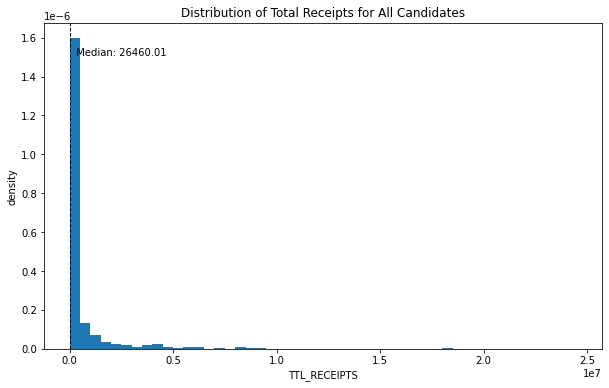

In [ ]:
# show the histogram of all candicates' TTL_RECEIPTS
plt.figure(figsize=(10, 6))
plt.hist(combined_df['TTL_RECEIPTS'], bins = np.arange(0,25000000,500000), density = True)
plt.axvline(median_receipts, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(median_receipts, max_ylim*0.9, '  Median: {:.2f}'.format(median_receipts))
plt.title('Distribution of Total Receipts for All Candidates')
plt.xlabel('TTL_RECEIPTS')
plt.ylabel('density')
#plt.savefig("/content/drive/My Drive/data 102 project data/figures/hist_ttl_receipts.png", bbox_inches = 'tight');

Text(0, 0.5, 'density')

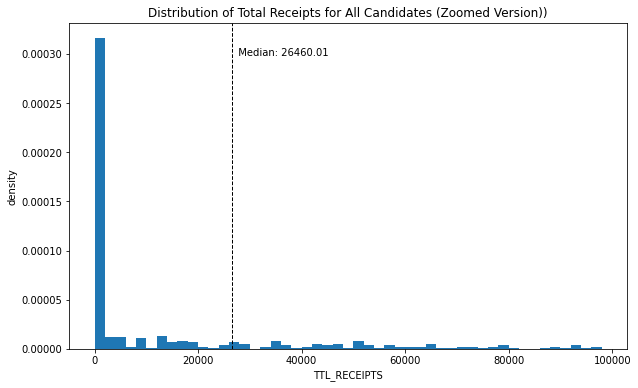

In [ ]:
# zoom in the data 
plt.figure(figsize=(10, 6))
plt.hist(combined_df['TTL_RECEIPTS'], bins = np.arange(0,100000,2000), density = True)
plt.axvline(median_receipts, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(median_receipts, max_ylim*0.9, '  Median: {:.2f}'.format(median_receipts))
plt.title('Distribution of Total Receipts for All Candidates (Zoomed Version))')
plt.xlabel('TTL_RECEIPTS')
plt.ylabel('density')
#plt.savefig("/content/drive/My Drive/data 102 project data/figures/hist_ttl_receipts_zoom.png", bbox_inches = 'tight');

### Plot the distribution of total receipts by the primary status of candidates

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0, 0.5, 'density')

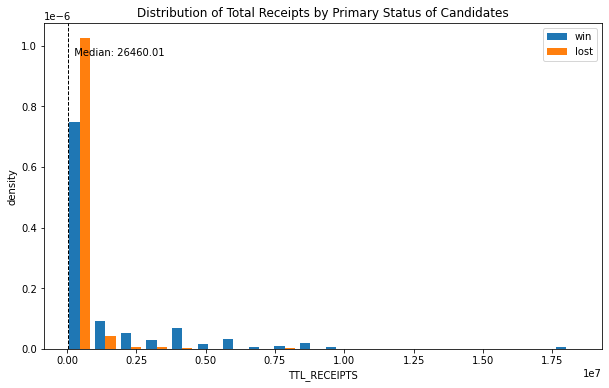

In [ ]:
win_finan = combined_df[combined_df['Advanced Primary']==1]
lost_finan = combined_df[combined_df['Advanced Primary']==0]

plt.figure(figsize=(10, 6))
plt.hist([win_finan['TTL_RECEIPTS'],lost_finan['TTL_RECEIPTS']],bins=20, density = True)
plt.legend(labels=["win","lost"])
plt.axvline(median_receipts, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(median_receipts, max_ylim*0.9, '  Median: {:.2f}'.format(median_receipts))
plt.title('Distribution of Total Receipts by Primary Status of Candidates')
plt.xlabel('TTL_RECEIPTS')
plt.ylabel('density')
#plt.savefig("/content/drive/My Drive/data 102 project data/figures/hist_ttl_receipts_by_primary_status.png", bbox_inches = 'tight');

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0, 0.5, 'density')

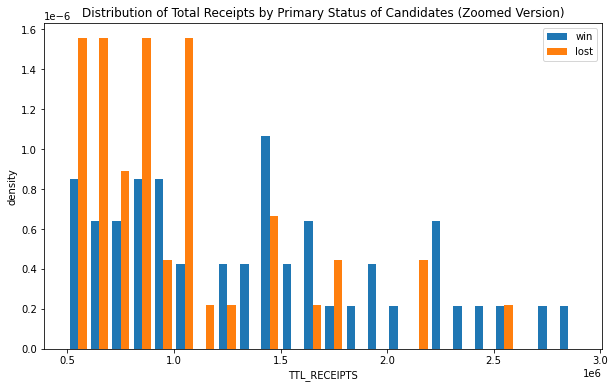

In [ ]:
# zoom in data
plt.figure(figsize=(10, 6))
plt.hist([win_finan['TTL_RECEIPTS'],lost_finan['TTL_RECEIPTS']],bins=np.arange(500000, 3000000, 100000), density = True)
plt.legend(labels=["win","lost"])
plt.title('Distribution of Total Receipts by Primary Status of Candidates (Zoomed Version)')
plt.xlabel('TTL_RECEIPTS')
plt.ylabel('density')
#plt.savefig("/content/drive/My Drive/data 102 project data/figures/hist_ttl_receipts_by_primary_status_zoom.png", bbox_inches = 'tight');

### Plot the boxplot grouped by primary status

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 1.05, 'Boxplot of Total Receiots Gouped by Primary Status')

<Figure size 720x432 with 0 Axes>

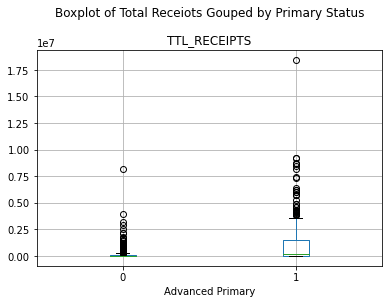

In [ ]:
plt.figure(figsize=(10, 6))
combined_df.boxplot(column='TTL_RECEIPTS', by='Advanced Primary')
plt.suptitle('Boxplot of Total Receiots Gouped by Primary Status', size=12, y=1.05)
#plt.savefig("/content/drive/My Drive/data 102 project data/figures/boxplot.png", bbox_inches = 'tight');

### Make a table showing the median total receipts for advanced candidates and lost candidates

In [ ]:
# median total receipts for advanced candidates and lost candidates
tb1 = combined_df[['Advanced Primary', 'TTL_RECEIPTS']].groupby(['Advanced Primary']).median()
tb1

,TTL_RECEIPTS
Advanced Primary,
0,8688.830
1,171501.225


## Explore the relationship between whether a candidates has over-median receipts and primary status

In [ ]:
# add a column Over Median to combined_df
combined_df['Over Median'] = np.where( combined_df['TTL_RECEIPTS'] >= median_receipts,1,0)

### Make a table showing the percentage of candidates having over-median receipts for advanced candidates and lost candidates

In [ ]:
# get the percentage of candidates who had receipts over median by primary status
tb2 = combined_df[['Advanced Primary', 'Over Median']].groupby(['Advanced Primary']).count().reset_index()
tb2['Percentage'] = 100 * combined_df[['Advanced Primary', 'Over Median']].groupby(['Advanced Primary']).sum().reset_index()['Over Median'] / tb2['Over Median']
tb2[['Advanced Primary', 'Percentage']]

,Advanced Primary,Percentage
0,0,40.816327
1,1,68.303571


## Explore confounding varables
Here we select race as an example to explore.


In [ ]:
# find the number of candidates who had receipts over median by race
tb3 = combined_df[['Is White', 'Over Median']].groupby(['Is White']).sum().reset_index()
tb3

,Is White,Over Median
0,0.0,106
1,1.0,227


In [ ]:
# find the number of candidates who won the Primary by race
tb4 = combined_df[['Is White', 'Advanced Primary']].groupby(['Is White']).sum().reset_index()
tb4

,Is White,Advanced Primary
0,0.0,66
1,1.0,158


In [ ]:
combined_df['Is White'].value_counts()

1.0    458
0.0    207
Name: Is White, dtype: int64

In [ ]:
# find the percentage of candidates who had receipts over median by race
tb5 = combined_df[['Is White', 'Over Median']].groupby(['Is White']).count().reset_index()
tb5['over median percentage'] = 100 * combined_df[['Is White','Over Median']].groupby(['Is White']).sum().reset_index()['Over Median']/tb5['Over Median']
tb5[['Is White','over median percentage']]

,Is White,over median percentage
0,0.0,51.207729
1,1.0,49.563319


In [ ]:
# find the percentage of candidates who advanced primary by race
tb6 = combined_df[['Is White', 'Advanced Primary']].groupby(['Is White']).count().reset_index()
tb6['pass primary percentage'] = 100 * combined_df[['Is White','Advanced Primary']].groupby(['Is White']).sum().reset_index()['Advanced Primary']/tb6['Advanced Primary']
tb6[['Is White','pass primary percentage']]

,Is White,pass primary percentage
0,0.0,31.884058
1,1.0,34.497817


## Data Preparation for Research Question 2

### Select five endorsement columns, which are all categorical variables - 'Yes', 'No', 'NaN'

In [ ]:
selected_endorsed_list = ['Biden Endorsed?', 'Warren Endorsed? ', 'Sanders Endorsed?', 'Our Revolution Endorsed?', 'Justice Dems Endorsed?']
q1_dem = dem_candidates.iloc[:,[0,6,22,23,24,25,26]]
q1_dem.head(5)

,Candidate,Primary Status,Biden Endorsed?,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?
0,Anthony White (Alabama),Lost,NaN,NaN,NaN,NaN,NaN
1,Christopher Countryman,Lost,NaN,NaN,NaN,NaN,NaN
2,"Doug ""New Blue"" Smith",Lost,NaN,NaN,NaN,NaN,NaN
3,James C. Fields,Lost,NaN,NaN,NaN,NaN,NaN
4,Sue Bell Cobb,Lost,NaN,NaN,NaN,NaN,NaN


In [ ]:
q1_dem['Biden Endorsed?'].unique(), q1_dem['Primary Status'].unique()

(array([nan, 'Yes', 'No'], dtype=object),
 array(['Lost', 'Advanced'], dtype=object))

### Replace 'NaN' to be -1, 'Yes' to be 1, and 'No' to be 0. 

In [ ]:
q1_dem_c = q1_dem.replace({np.nan : -1, 'Yes' : 1, 'No' : 0})
q1_dem_c.head(5)

,Candidate,Primary Status,Biden Endorsed?,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?
0,Anthony White (Alabama),Lost,-1,-1,-1,-1,-1
1,Christopher Countryman,Lost,-1,-1,-1,-1,-1
2,"Doug ""New Blue"" Smith",Lost,-1,-1,-1,-1,-1
3,James C. Fields,Lost,-1,-1,-1,-1,-1
4,Sue Bell Cobb,Lost,-1,-1,-1,-1,-1


### Add noise to these columns, and same range of noise for each column

In [ ]:
def add_random_noise(df, cols):
  new_cols = []
  for col in cols:
    new_col = 'temp_' + col
    min_noise, max_noise = 0.01, 0.5
    df[new_col] = [float(x) + random.uniform(min_noise, max_noise) for x in df[col].to_list()]
    new_cols.append(new_col)
  return df[new_cols], new_cols

In [ ]:
q1_dem_noise, noise_cols = add_random_noise(q1_dem_c, selected_endorsed_list)
q1_dem_noise.head(5)

,temp_Biden Endorsed?,temp_Warren Endorsed?,temp_Sanders Endorsed?,temp_Our Revolution Endorsed?,temp_Justice Dems Endorsed?
0,-0.904908,-0.925395,-0.671960,-0.529125,-0.894198
1,-0.942308,-0.725633,-0.830909,-0.760638,-0.533073
2,-0.849669,-0.791915,-0.546150,-0.535273,-0.529000
3,-0.548701,-0.762373,-0.956874,-0.956484,-0.835524
4,-0.611591,-0.962257,-0.647495,-0.816867,-0.589271


## 1. Draw graphs to check defendency between endorsement columns

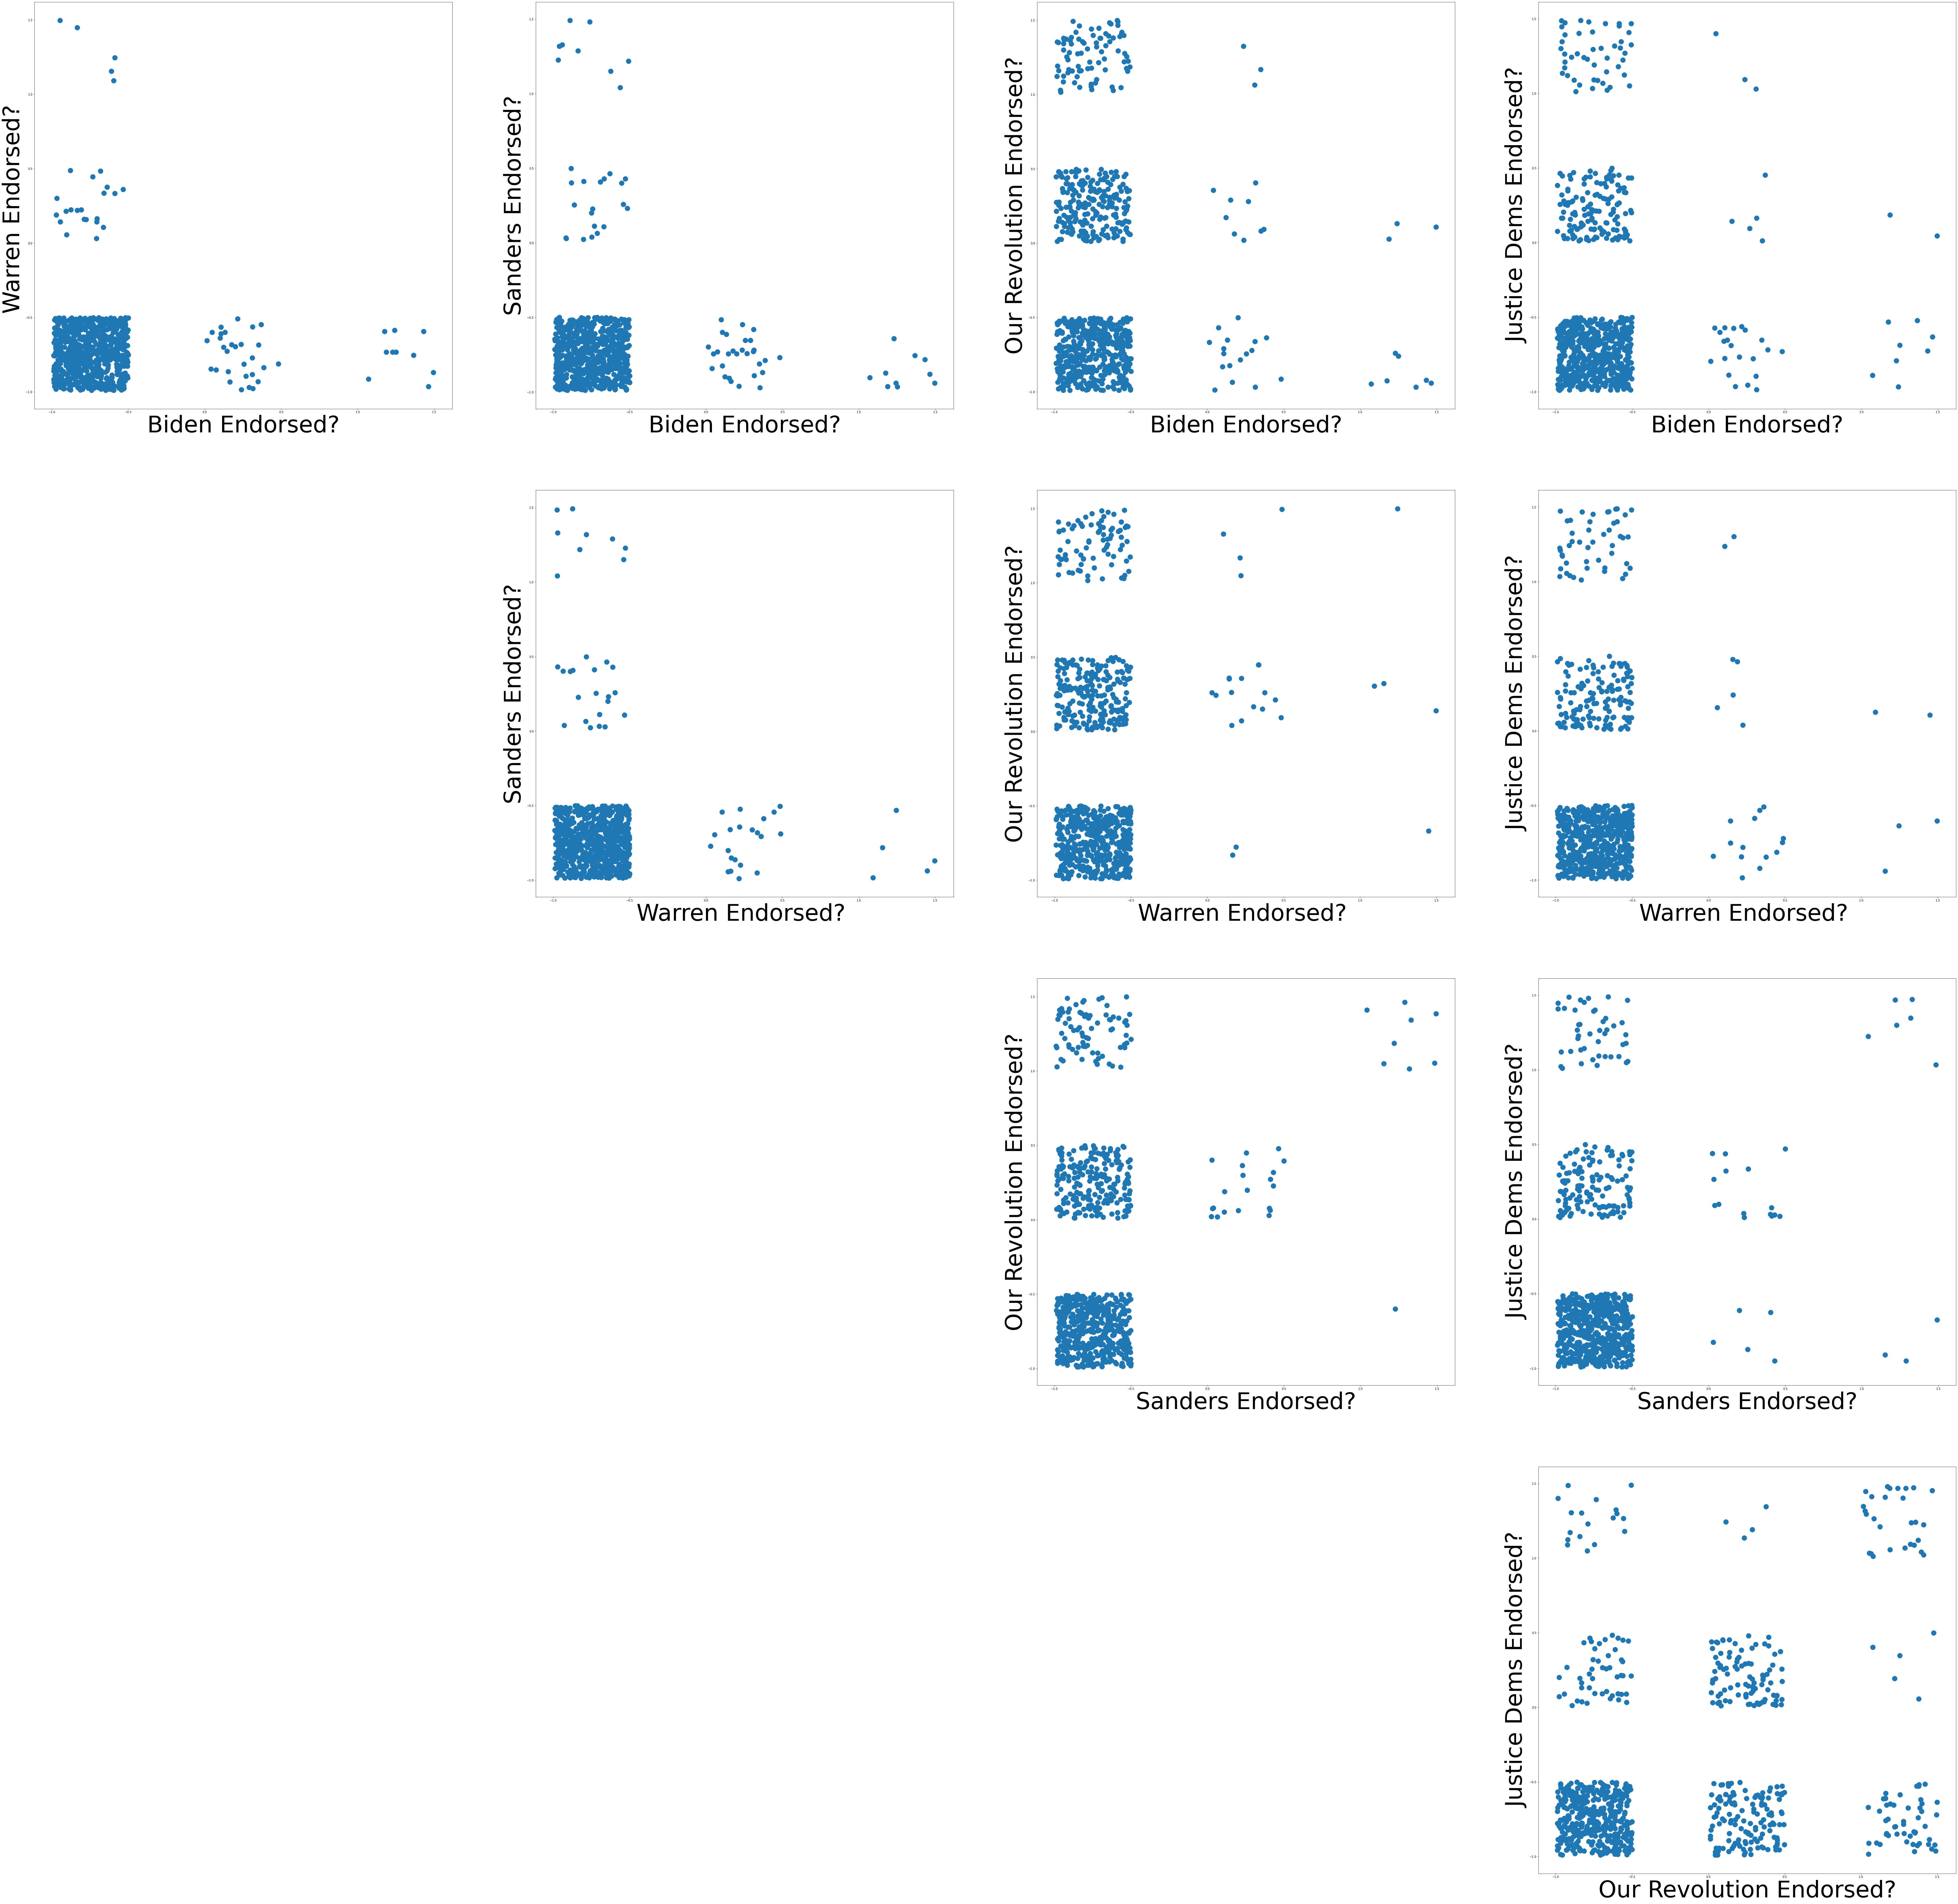

In [ ]:
dimension = len(noise_cols)-1
fig, axes = plt.subplots(nrows=dimension, ncols=dimension, figsize=(120, 120))
count = 1
for row in range(0, dimension):
  one = noise_cols[row]
  for col in range(1, dimension+1):
    if col <= row:
      axes[row, col-1].axis('off')
      count += 1
      continue
    ax = plt.subplot(dimension, dimension, count)

    other = noise_cols[col]
    plt.scatter(q1_dem_noise[one], q1_dem_noise[other], s=300)

    count += 1
    ax.set_title('')
    ax.set_xlabel(one.replace('temp_', ""), fontsize=80)
    ax.set_ylabel(other.replace('temp_', ""), fontsize=80)
#plt.savefig("/content/drive/My Drive/data 102 project data/figures/scatter_endorsement_.png", bbox_inches = 'tight')
plt.show();

## 2. Draw graphs to check the effect of every single endorsement on the election result of candidates

In [ ]:
q1_dem_b = q1_dem.replace({'Lost' : 0, 'Advanced' : 1})
q1_dem_b.head(5)

,Candidate,Primary Status,Biden Endorsed?,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?
0,Anthony White (Alabama),0,NaN,NaN,NaN,NaN,NaN
1,Christopher Countryman,0,NaN,NaN,NaN,NaN,NaN
2,"Doug ""New Blue"" Smith",0,NaN,NaN,NaN,NaN,NaN
3,James C. Fields,0,NaN,NaN,NaN,NaN,NaN
4,Sue Bell Cobb,0,NaN,NaN,NaN,NaN,NaN


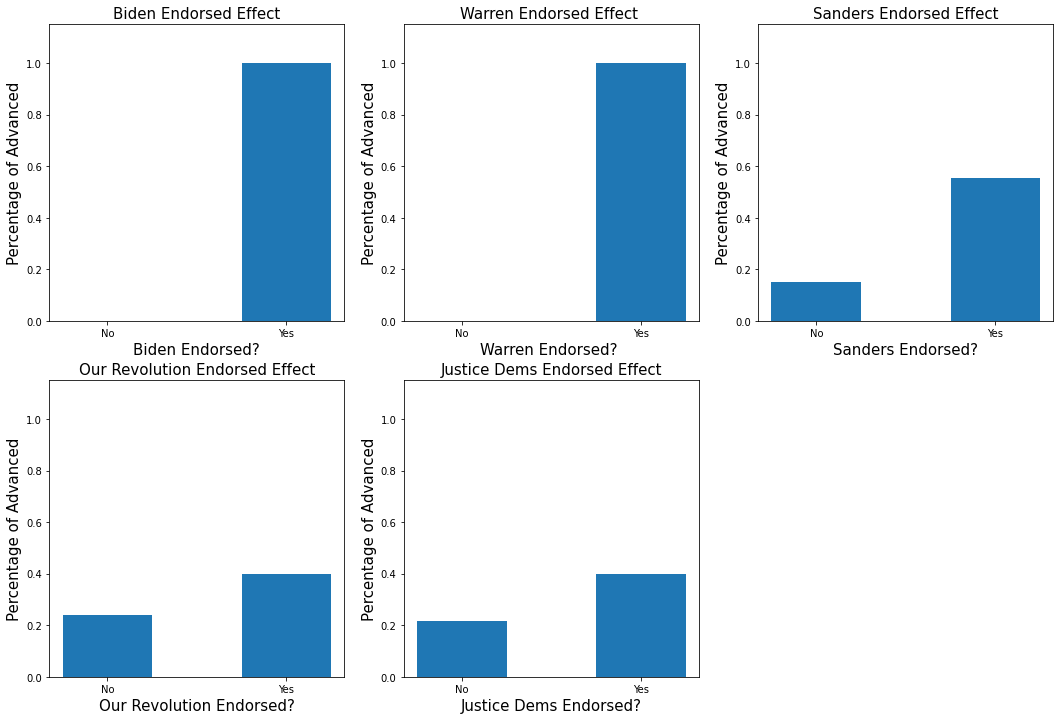

In [ ]:
dimension = len(selected_endorsed_list)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

for i in range(1, dimension+1):
  ax = plt.subplot(2, 3, i)

  col_name = selected_endorsed_list[i-1]
  effect_df = q1_dem_b.groupby(col_name).mean().reset_index()
  plt.bar(['No', 'Yes'], effect_df['Primary Status'], width = 0.5)

  ax.set_xlabel(col_name, fontsize=15)
  ax.set_ylabel('Percentage of Advanced', fontsize=15)
  ax.set_title(col_name.replace('?', ' Effect'), fontsize=15)
  ax.set_ylim([0, 1.15])


axes[1, 2].axis('off')
#plt.savefig("/content/drive/My Drive/data 102 project data/figures/bar_endorsement_.png", bbox_inches = 'tight')
plt.show();

# Results

##  Multiple Hypothesis

In [ ]:
def bonferroni(p_values, alpha_total):
    """
    Returns decisions on p-values using the Bonferroni correction.
    
    Inputs:
        p_values: array of p-values
        alpha_total: desired family-wise error rate (FWER = P(at least one false discovery))
    
    Returns:
        decisions: binary array of same length as p-values, where `decisions[i]` is 1
        if `p_values[i]` is deemed significant, and 0 otherwise
    """

    decisions =  p_values<= alpha_total/len(p_values)
    return decisions
    

In [ ]:
def benjamini_Yekutieli_procedure(p_values, alpha):
    """
    Returns decisions on p-values using Benjamini-Hochberg.
    
    Inputs:
        p_values: array of p-values
        alpha: desired FDR (FDR = E[# false positives / # positives])
    
    Returns:
        decisions: binary array of same length as p-values, where `decisions[i]` is 1
        if `p_values[i]` is deemed significant, and 0 otherwise
    """
    sortval = sorted(p_values)
    empty = []
    c_m = 0
    for i in range(1,len(p_values)+1):
      c_m += 1/i
    for k in range(len(p_values)):
        if sortval[k] <= (k+1)*alpha / (len(p_values) * c_m):
            empty = np.append(empty,sortval[k])
        
    decisions = p_values <= max(empty)
    return decisions

In [ ]:
null = len(dem_candidates[dem_candidates['Primary Status'] == 'Advanced']) / len(dem_candidates)
dem_candidates_0_1 = dem_candidates.replace({np.nan : 0, 'Yes' : 1, 'No' : 0})

## we want to simulate 10000 times with number of times based on how many data each politician has
## null is n = 0.33
## alt is n > 0.33
# we assumed their distribution is binomial distribution
## biden endosed distribution  p = 
def test(col_name):
  dem = dem_candidates_0_1[dem_candidates_0_1[col_name] == 1]
  prob_dem_success = len(dem[dem['Primary Status'] == 'Advanced']) / len(dem)
  candidate_size = np.sum(dem[col_name])
  print("candidate size: ", candidate_size)
  s = np.random.binomial(candidate_size, null, 10000)
  plt.hist(x = s)
  plt.xlabel('number of advanced candidate for each sample')
  plt.ylabel('frequency')
  title = f'''Empirical Distribution of {col_name}'''
  plt.title(title)
  #plt.savefig(f'''/content/drive/My Drive/data 102 project data/figures/{title}.png''', bbox_inches = 'tight')
  print(sum(s >= prob_dem_success * candidate_size) / len(s))

candidate size:  10
0.0001


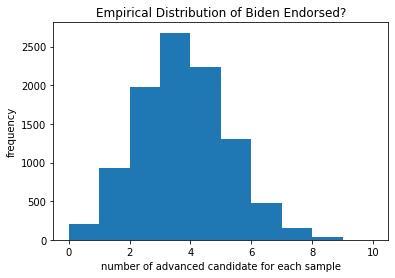

In [ ]:
test('Biden Endorsed?')

candidate size:  5
0.004


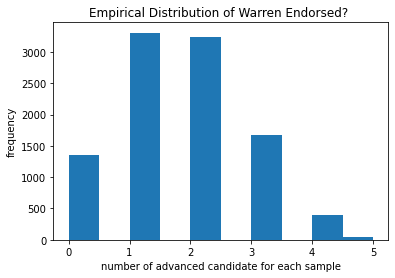

In [ ]:
test('Warren Endorsed? ')

candidate size:  9
0.1304


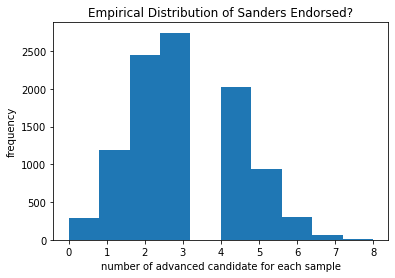

In [ ]:
test('Sanders Endorsed?')

candidate size:  85
0.0953


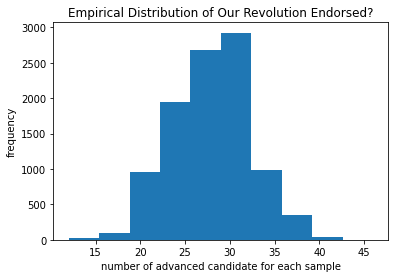

In [ ]:
test('Our Revolution Endorsed?')

candidate size:  50
0.1635


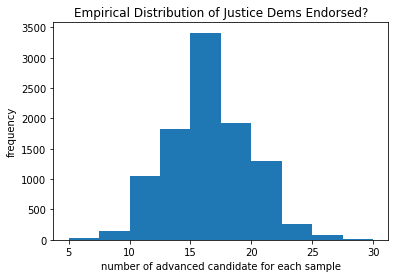

In [ ]:
test('Justice Dems Endorsed?')

In [ ]:
p_values = np.array([0.0,0.003,0.1,0.13,0.17])

In [ ]:
bonferroni(p_values, 0.05)

array([ True,  True, False, False, False])

In [ ]:
benjamini_Yekutieli_procedure(p_values, 0.05)

array([ True,  True, False, False, False])

In [ ]:
d = {'bonferroni': bonferroni(p_values, 0.05), 'benjamini_Yekutieli_procedure': benjamini_Yekutieli_procedure(p_values, 0.05)}
df = pd.DataFrame(data=d)
df

,bonferroni,benjamini_Yekutieli_procedure
0,True,True
1,True,True
2,False,False
3,False,False
4,False,False


## Causal Inference

### Methods


- Treatment: receiving the amount of funds that is higher than the median financing amount. 

- Outcome: the candidate's promary status (whether a candidate won the primary election). 

- Each unit is a democratic candidate in the primary election. 

- Confounding variables: Race, Veteran?, LGBTQ?, Elected Official?, Self-Funder?, STEM?, Guns Sense Candidate?, Endorsed? 

- Since there are many confounding factors, we will use the inverse propensity weights which first calculate the propensity scores and then get the average treatment effect. 

In [ ]:
combined_df.columns

Index(['Candidate', 'Advanced Primary', 'Is White', 'Veteran?', 'LGBTQ?',
       'Elected Official?', 'Self-Funder?', 'STEM?', 'Emily Endorsed?',
       'Guns Sense Candidate?', 'Biden Endorsed?', 'Warren Endorsed? ',
       'Sanders Endorsed?', 'Our Revolution Endorsed?',
       'Justice Dems Endorsed?', 'PCCC Endorsed?', 'Indivisible Endorsed?',
       'WFP Endorsed?', 'VoteVets Endorsed?', 'No Labels Support?',
       'TTL_RECEIPTS', 'Over Median'],
      dtype='object')

In [ ]:
from sklearn.linear_model import LogisticRegression as LR 

# treatment 
Z = np.array(combined_df['Over Median'])

# outcome 
Y = np.array(combined_df['Advanced Primary'])

# confounders
X = np.array(combined_df.iloc[:,2:20])

# fit a logistic regression model 
lr = LR(penalty='none', max_iter=200, random_state=0)
lr.fit(X,Z)

# estimate treatment accounting for the propensity
def estimate_treatment_effect(lr, X, Y, Z):
  """
    Returns estimated average treatment effect computed by IPW.
    
    Inputs:
        lr: LogisticRegression object representing a trained logistic regression model
        X: array of confounders
        Y: array of outcome
        Z: array of treatment
    
    Returns:
        ate: numerical value of average treatment effect
    """
  e_hat = lr.predict_proba(X)[:,1] #class = 1的那一列，也就是Y=1，因为python中本身1就代表第二列
  n = len(X)
  ate = 1/n * sum(Z*Y/e_hat - (1-Z)*Y/(1-e_hat)) # n 就是row， 为了完成概率计算
  #Y自身的概率就默认包含了P（Z｜X），所以我们要在分母上除掉P（Z｜X），也就是e_hat.
  return ate

ate = estimate_treatment_effect(lr, X, Y, Z)
ate

0.1711614938542241

In [ ]:
len(X)

665

In [ ]:
len(Y)

665

In [ ]:
len(Z)

665

In [ ]:
len(lr.predict_proba(X)[:,1])

665

Since in multiple hypothesis, we failed to reject that the endorsement of Our Revolution and Justice Dems would not affect a candidate's primary status, we decide to remove Our Revolution Endorsed? Justice Dems Endorsed? in our confounding variables.

In [ ]:
# confounders
X_improved = np.array(combined_df.iloc[:,np.r_[2:13, 15:20]])

# fit a logistic regression model 
lr_improved = LR(penalty='none', max_iter=200, random_state=0)
lr_improved.fit(X_improved,Z)

# estimate treatment accounting for the propensity
ate_improved = estimate_treatment_effect(lr_improved, X_improved, Y, Z)
ate_improved

0.19193014585913157

#### Bootstrap Confidence Intervel

To address the uncertainty issue in our ATE estimation, we bootstrap 2,000 times and  construct an approximate 95% confidence interval for the ATE.


In [ ]:
# define the function to compute ate in one bootstrap
def one_bootstrap_ate():
  """
    Returns estimated average treatment effect computed by IPW in a single bootstrap.

    Returns:
        ate: numerical value of average treatment effect computed in a single bootstrap.
    """
  resample = combined_df.sample(n = combined_df.shape[0], replace = True)
  #2000个抽，有些人会被抽不止一次
  #simulate: boostrap 抽2000次，画histogram = 中心极限定理，画histogram
  # row = 2000，simulation = 2000

  # treatment 
  Z = np.array(resample['Over Median'])
  # outcome 
  Y = np.array(resample['Advanced Primary'])
  # confounders
  X = np.array(resample.iloc[:,np.r_[2:13, 15:20]])

  # fit a logistic regression model 
  lr = LR(penalty='none', max_iter=200, random_state=0)
  lr.fit(X,Z)

  # calculate ate
  ate = estimate_treatment_effect(lr, X, Y, Z)
  return ate

In [ ]:
# set random seed
np.random.seed(10) 

# ignore the warning message
np.seterr(divide='ignore', invalid='ignore')

# generate 2000 bootstrap ATEs
num_repetitions = 2000
bstrap_ates = np.array([])
for i in np.arange(num_repetitions):
    bstrap_ates = np.append(bstrap_ates, one_bootstrap_ate())

# remove nan generated by getting e_hat equal to 0
bstrap_ates = bstrap_ates[~np.isnan(bstrap_ates)]

# get the endpoints of the 95% confidence interval
left = np.percentile(bstrap_ates, 2.5)
right = np.percentile(bstrap_ates, 97.5)

print("95% confidence interval of ATE is [", left, ", ", right, "]")

95% confidence interval of ATE is [ 0.11745733576720681 ,  0.2685788892353458 ]


Text(0.5, 1.0, 'Histogram of 2000 Bootstrap ATE')

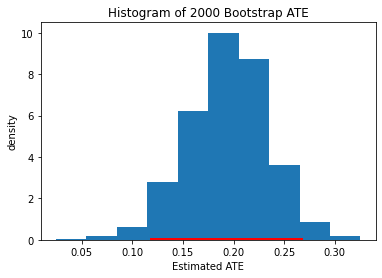

In [ ]:
# draw the 95% confidence interval for ATE
plt.hlines(y=0, xmin=left, xmax=right, linewidth=4, color='r')
# draw the histogram of bootstrapped ATE
plt.hist(bstrap_ates, density = True)
plt.xlabel("Estimated ATE")
plt.ylabel("density")
plt.title("Histogram of 2000 Bootstrap ATE")
#plt.savefig("/content/drive/My Drive/data 102 project data/figures/hist_bootstrap.png");